In [1]:
import os
from functools import wraps
import numpy as np
import copy
import random
from torchvision import transforms, utils, datasets
from utils.utils import *
from utils.training import *
# from utils.training_batch import *
from utils.model import *
from utils.BYOL_models import *


/home/haken/.conda/envs/splitfedssl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set manual seed for reproducibility
seed = 1234

In [3]:
# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# ('mnist', 'femnist', 'fmnist', 'cifar10', 'cifar100', 'svhn')
data_path = "./data"
dataset = "cifar10"
# ('noniid-labeldir', 'iid', 'default') default only for femnist
partition = "noniid-labeldir"
client_num = 5
batch_size = 32
test_batch = 128

In [6]:
# Hyperparameters_List (H) = [rounds, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client, aggregation_frequence]

global_epochs = 1000
lr = 3e-4
dirichlet_beta = 0.4
norm = 'bn'
# every (avg_freq) epochs doing one aggregation
# avg_freq = 2
avg_freq = "linear"

# save_path = f"./model/SplitFSSLMaxpool_resnet18/resnet18Maxpooling_cifar10_{batch_size}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}"
save_path = f"./model/SplitFSSL_BYOL32_DifAvgtimes/resnet18Maxpooling_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
H = [global_epochs, client_num, batch_size, lr, avg_freq]

In [7]:
# partition
net_dataidx_map, net_dataidx_map_test, traindata_cls_counts, testdata_cls_counts = partition_data(dataset, data_path, partition, client_num)

# get dataloader
train_loader_list = []
test_loader_list = []
for idx in range(client_num):
    
    dataidxs = net_dataidx_map[idx]
    if net_dataidx_map_test is None:
        dataidx_test = None 
    else:
        dataidxs_test = net_dataidx_map_test[idx]

    train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(dataset, 
                                                                   data_path, batch_size, test_batch, 
                                                                   dataidxs, dataidxs_test)
    train_loader_list.append(train_dl_local)
    test_loader_list.append(test_dl_local)


Files already downloaded and verified
Files already downloaded and verified
partition: noniid-labeldir
Data statistics Train: {0: {0: 2921, 1: 3, 2: 1440, 3: 2284, 4: 2849, 5: 1966}, 1: {0: 1265, 1: 1562, 2: 515, 4: 1070, 5: 496, 6: 2247, 7: 308, 8: 11, 9: 2637}, 2: {0: 91, 1: 124, 2: 203, 3: 2255, 4: 93, 5: 489, 6: 898, 7: 2460, 8: 283, 9: 2268}, 3: {0: 543, 1: 31, 2: 1028, 3: 61, 4: 987, 5: 534, 6: 4, 7: 2214, 8: 47, 9: 95}, 4: {0: 180, 1: 3280, 2: 1814, 3: 400, 4: 1, 5: 1515, 6: 1851, 7: 18, 8: 4659}}
Data statistics Test:
 {0: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000}, 1: {0: 1000, 1: 1000, 2: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}, 2: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}, 3: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}, 4: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000}} 



In [8]:
net = ResNet18()
client_model = BYOL_Client()
server_model = BYOL_Server()
server_model.cuda()

client_weights = [1/5 for i in range(client_num)]
client_models = [copy.deepcopy(client_model).cuda() for idx in range(client_num)]
# server_models = [copy.deepcopy(server_model).cuda() for idx in range(client_num)]

optimizer_server = torch.optim.Adam(server_model.parameters(), lr = H[3]) 
optimizer_clients = [torch.optim.Adam(client_models[i].parameters(), lr = H[3]) for i in range(len(client_models))]

In [9]:
# if using checkpoint to train
# epoch = 0
checkpath = save_path + "/checkpoint.pth.tar" 
checkpoint = torch.load(checkpath)
epoch = checkpoint['glepoch']
print(epoch)
optimizer_server.load_state_dict(checkpoint['optimizer'][0])
for localmodel in client_models:
    localmodel.online_encoder.load_state_dict(checkpoint['state_dict'])
for clientidx in range(client_num):
    optimizer_clients[clientidx].load_state_dict(checkpoint['optimizer'][clientidx+1])

796


In [10]:
client_model

BYOL_Client(
  (online_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [11]:
def training(client_models, server_model, optimizer_server, optimizer_clients, rounds, batch_size, avg_freq):
   
    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    avg_times = 0
    # measure time
    start = time.time()
    
    
    # writer = SummaryWriter(f'logs/SplitFSSL_BYOL32_DifAvgtimes/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{noniid_ratio}_{client_num}')
    writer = SummaryWriter(f'logs/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}')
    global_step = 0
    for curr_round in range(epoch, rounds + 1):
        metrics = defaultdict(list)
        print(f"Global Round:", curr_round)
        w, local_loss = [], []
        
        num_batch = 0
        for i in train_loader_list:
            if num_batch < len(i):
                num_batch = len(i)
                
        train_iter = []
        for i in train_loader_list:
            train_iter.append(iter(i))
            
        batch_time = AverageMeter()
        data_time = AverageMeter()
        p_bar = tqdm(range(num_batch))

        # 聚合頻率參數成指數成長
        # alpha = expavg_times(curr_round)
        # 聚合頻率參數線性數成長
        alpha = linear_growth(curr_round)
        
        for batch in range(num_batch):
            # print("0>", time.time() - start)
            optimizer_zero_grads(optimizer_server, optimizer_clients)
            
            online_proj_one_list = [None for _ in range(5)]
            online_proj_two_list = [None for _ in range(5)]
            target_proj_one_list = [None for _ in range(5)]
            target_proj_two_list = [None for _ in range(5)]

            # client forward
            # select 5 client to join training
            s_clients = []
            s_clients = random.sample(range(client_num), 5)
            # print("1>", time.time() - start)
            for i, client_id in enumerate(s_clients):
                # print("Client: ",i)
                # Compute a local update
                # print(i, "0>", time.time() - start)
                img1, img2 = next_data_batch(train_iter[client_id], train_loader_list[client_id])
                
                img1 = img1.cuda()
                img2 = img2.cuda()
                
                data_time.update(time.time() - start)
                # print(i, "1>", time.time() - start)
                # pass to client model
                # print("pass to client model")
                client_models[client_id].train()
                # print(i, "2>", time.time() - start)
                online_proj_one, online_proj_two, target_proj_one, target_proj_two = client_models[client_id](img1, img2)
                # print(i, "3>", time.time() - start)
                
                # store representations
                online_proj_one_list[i] = online_proj_one
                online_proj_two_list[i] = online_proj_two
                target_proj_one_list[i] = target_proj_one
                target_proj_two_list[i] = target_proj_two
                  

            # stack representations
            stack_online_proj_one = torch.cat(online_proj_one_list, dim = 0)
            stack_online_proj_two = torch.cat(online_proj_two_list, dim = 0)
            stack_target_proj_one = torch.cat(target_proj_one_list, dim = 0)
            stack_target_proj_two = torch.cat(target_proj_two_list, dim = 0)

            # print(">", time.time() - start)
            stack_online_proj_one, stack_online_proj_two, stack_target_proj_one, stack_target_proj_two = stack_online_proj_one.cuda(), stack_online_proj_two.cuda(), stack_target_proj_one.cuda(), stack_target_proj_two.cuda()
            
            # server computes
            # print("server computes")
            online_proj_one_grad, online_proj_two_grad, loss = train_server(stack_online_proj_one.detach(), stack_online_proj_two.detach(), stack_target_proj_one, stack_target_proj_two, server_model)
            local_loss.append((loss.item()))
            optimizer_server.step()
            
            # print(time.time() - start)
            # distribute gradients to clients
            # online_proj_one_grad, online_proj_two_grad = online_proj_one_grad.cpu(), online_proj_two_grad.cpu()
            gradient_dict_one = {key: [] for key in range(client_num)}
            gradient_dict_two = {key: [] for key in range(client_num)}
            
            for j in range(5):
                gradient_dict_one[j] = online_proj_one_grad[j*batch_size:(j+1)*batch_size, :]
                gradient_dict_two[j] = online_proj_two_grad[j*batch_size:(j+1)*batch_size, :]
                
            
            for i, client_id in enumerate(s_clients):
                online_proj_one_list[i].backward(gradient_dict_one[i])
                online_proj_two_list[i].backward(gradient_dict_two[i])
                optimizer_clients[client_id].step()
                client_models[client_id].update_moving_average()
            
            # if (batch+1)%10 == 0:
            #     print(f"Step [{batch}/{num_batch}]:\tLoss: {loss.item()}")
            
            del img1, img2
            writer.add_scalar("Loss/train_step", loss, global_step)
            metrics["Loss/train"].append(loss.item())
            global_step += 1
            
            batch_time.update(time.time() - start)
            start = time.time()
            #=======================================set p_bar description=======================================================
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. alpha: {ep_alpha}. Batch: {bt:.3f}s. Loss: {loss:.4f}.".format(
                    epoch=curr_round,
                    epochs=rounds+1,
                    batch=batch + 1,
                    iter=num_batch,
                    data=data_time.avg,
                    ep_alpha = alpha,
                    bt=batch_time.avg,
                    loss=loss.item()))
            p_bar.update()
            #=======================================set p_bar description=======================================================
            # in 32 batch size will have 250 batches, if aggregate per 10 batches will have 25 aggerations in one epoch
            # in 64 batch size will have 125 batches, if aggregate per 5 batches will have 25 aggerations in one epoch
            if batch == num_batch - 1 or ((batch+1) % alpha == 0):
                # print("aggregate batch", batch)
                avg_times += 1
                with torch.no_grad():
                    # aggregate client models
                    for key in client_model.state_dict().keys():
                        # num_batches_tracked is a non trainable LongTensor and
                        # num_batches_tracked are the same for all clients for the given datasets
                        if "running" in key or "num_batches" in key:
                            continue
                        # elif 'target' in key:
                        #     continue
                        else:
                            temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                            for client_idx in s_clients:
                                temp += client_weights[client_idx] * client_models[client_idx].state_dict()[key]                        
                            client_model.state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                client_models[client_idx].state_dict()[key].data.copy_(client_model.state_dict()[key])
        
        
        p_bar.close()
        # scheduler_server.step()
        for k, v in metrics.items():
            writer.add_scalar(k, np.array(v).mean(), curr_round)


        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)
        if curr_round % 5 == 0:
            optimizer_dict = []
            optimizer_dict.append(optimizer_server.state_dict())
            for client_idx in range(client_num):
                optimizer_dict.append(optimizer_clients[client_idx].state_dict())
            state_dict = client_model.online_encoder.cpu().state_dict()
            save_checkpoint({
                'glepoch': curr_round+1,
                'state_dict': state_dict,
                'optimizer': optimizer_dict,
            }, save_path)
        if curr_round % 100 == 0:
            torch.save(client_model.online_encoder.cpu().state_dict(), save_path + f"_{curr_round}_epoch.pt")
        
        
        print(f"Global round: {curr_round} | Average loss: {loss_avg}")
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
   
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))
    print(f"Total average times : {avg_times}")

    return client_model, train_loss

In [12]:
# plot_str = partition + '_' + norm + '_' + 'comm_rounds_' + str(global_epochs) + '_numclients_' + str(client_num) + '_clientbs_' + str(batch_size) + '_clientLR_' + str(lr)
print(save_path)

./model/SplitFSSL_BYOL32_DifAvgtimes/resnet18Maxpooling_cifar10_32_linear_noniid-labeldir_5


In [13]:
client_models, train_loss = training(client_models, server_model, optimizer_server, optimizer_clients, H[0], H[2], H[4])

Global Round: 796


Train Epoch: 796/1001. Iter:  428/ 428. Data: 0.114s. alpha: 40. Batch: 0.340s. Loss: 0.0224.: 100%|█| 428/428 [02:25<00:0


Global round: 796 | Average loss: 0.062038993911173575
Global Round: 797


Train Epoch: 797/1001. Iter:  428/ 428. Data: 0.114s. alpha: 40. Batch: 0.338s. Loss: 0.0189.: 100%|█| 428/428 [02:24<00:0


Global round: 797 | Average loss: 0.02234139549328345
Global Round: 798


Train Epoch: 798/1001. Iter:  428/ 428. Data: 0.111s. alpha: 40. Batch: 0.333s. Loss: 0.0197.: 100%|█| 428/428 [02:22<00:0


Global round: 798 | Average loss: 0.020505928538878945
Global Round: 799


Train Epoch: 799/1001. Iter:  428/ 428. Data: 0.114s. alpha: 40. Batch: 0.338s. Loss: 0.0187.: 100%|█| 428/428 [02:24<00:0


Global round: 799 | Average loss: 0.020184296470518424
Global Round: 800


Train Epoch: 800/1001. Iter:  428/ 428. Data: 0.114s. alpha: 40. Batch: 0.337s. Loss: 0.0184.: 100%|█| 428/428 [02:24<00:0


global epoch 801 saved
Global round: 800 | Average loss: 0.020116345251901684
Global Round: 801


Train Epoch: 801/1001. Iter:  428/ 428. Data: 0.118s. alpha: 40. Batch: 0.343s. Loss: 0.0205.: 100%|█| 428/428 [02:26<00:0


Global round: 801 | Average loss: 0.020447752730067922
Global Round: 802


Train Epoch: 802/1001. Iter:  428/ 428. Data: 0.118s. alpha: 40. Batch: 0.343s. Loss: 0.0223.: 100%|█| 428/428 [02:26<00:0


Global round: 802 | Average loss: 0.02116208932162306
Global Round: 803


Train Epoch: 803/1001. Iter:  428/ 428. Data: 0.117s. alpha: 41. Batch: 0.342s. Loss: 0.0208.: 100%|█| 428/428 [02:26<00:0


Global round: 803 | Average loss: 0.02192130602600279
Global Round: 804


Train Epoch: 804/1001. Iter:  428/ 428. Data: 0.116s. alpha: 41. Batch: 0.340s. Loss: 0.0253.: 100%|█| 428/428 [02:25<00:0


Global round: 804 | Average loss: 0.023143773123830834
Global Round: 805


Train Epoch: 805/1001. Iter:  428/ 428. Data: 0.114s. alpha: 41. Batch: 0.338s. Loss: 0.0255.: 100%|█| 428/428 [02:24<00:0


global epoch 806 saved
Global round: 805 | Average loss: 0.024675961966826535
Global Round: 806


Train Epoch: 806/1001. Iter:  428/ 428. Data: 0.118s. alpha: 41. Batch: 0.344s. Loss: 0.0274.: 100%|█| 428/428 [02:26<00:0


Global round: 806 | Average loss: 0.0265483527278928
Global Round: 807


Train Epoch: 807/1001. Iter:  428/ 428. Data: 0.117s. alpha: 41. Batch: 0.342s. Loss: 0.0281.: 100%|█| 428/428 [02:26<00:0


Global round: 807 | Average loss: 0.027811854007157768
Global Round: 808


Train Epoch: 808/1001. Iter:  428/ 428. Data: 0.115s. alpha: 41. Batch: 0.338s. Loss: 0.0311.: 100%|█| 428/428 [02:24<00:0


Global round: 808 | Average loss: 0.029181436613793965
Global Round: 809


Train Epoch: 809/1001. Iter:  428/ 428. Data: 0.115s. alpha: 41. Batch: 0.340s. Loss: 0.0291.: 100%|█| 428/428 [02:25<00:0


Global round: 809 | Average loss: 0.030573553880067352
Global Round: 810


Train Epoch: 810/1001. Iter:  428/ 428. Data: 0.115s. alpha: 41. Batch: 0.339s. Loss: 0.0335.: 100%|█| 428/428 [02:25<00:0


global epoch 811 saved
Global round: 810 | Average loss: 0.03185395594407743
Global Round: 811


Train Epoch: 811/1001. Iter:  428/ 428. Data: 0.117s. alpha: 41. Batch: 0.341s. Loss: 0.0352.: 100%|█| 428/428 [02:25<00:0


Global round: 811 | Average loss: 0.03358811647065471
Global Round: 812


Train Epoch: 812/1001. Iter:  428/ 428. Data: 0.114s. alpha: 41. Batch: 0.339s. Loss: 0.0360.: 100%|█| 428/428 [02:25<00:0


Global round: 812 | Average loss: 0.03485657538452717
Global Round: 813


Train Epoch: 813/1001. Iter:  428/ 428. Data: 0.115s. alpha: 41. Batch: 0.340s. Loss: 0.0350.: 100%|█| 428/428 [02:25<00:0


Global round: 813 | Average loss: 0.036118798828292116
Global Round: 814


Train Epoch: 814/1001. Iter:  428/ 428. Data: 0.116s. alpha: 41. Batch: 0.341s. Loss: 0.0358.: 100%|█| 428/428 [02:26<00:0


Global round: 814 | Average loss: 0.036916520611913965
Global Round: 815


Train Epoch: 815/1001. Iter:  428/ 428. Data: 0.116s. alpha: 41. Batch: 0.341s. Loss: 0.0388.: 100%|█| 428/428 [02:25<00:0


global epoch 816 saved
Global round: 815 | Average loss: 0.03793419061977173
Global Round: 816


Train Epoch: 816/1001. Iter:  428/ 428. Data: 0.120s. alpha: 41. Batch: 0.346s. Loss: 0.0387.: 100%|█| 428/428 [02:26<00:0


Global round: 816 | Average loss: 0.03886413059815347
Global Round: 817


Train Epoch: 817/1001. Iter:  428/ 428. Data: 0.118s. alpha: 41. Batch: 0.343s. Loss: 0.0374.: 100%|█| 428/428 [02:26<00:0


Global round: 817 | Average loss: 0.03979589646490656
Global Round: 818


Train Epoch: 818/1001. Iter:  428/ 428. Data: 0.116s. alpha: 41. Batch: 0.342s. Loss: 0.0444.: 100%|█| 428/428 [02:26<00:0


Global round: 818 | Average loss: 0.04104218820858503
Global Round: 819


Train Epoch: 819/1001. Iter:  428/ 428. Data: 0.115s. alpha: 41. Batch: 0.341s. Loss: 0.0454.: 100%|█| 428/428 [02:25<00:0


Global round: 819 | Average loss: 0.042105773411621555
Global Round: 820


Train Epoch: 820/1001. Iter:  428/ 428. Data: 0.114s. alpha: 41. Batch: 0.338s. Loss: 0.0399.: 100%|█| 428/428 [02:24<00:0


global epoch 821 saved
Global round: 820 | Average loss: 0.043594794147691435
Global Round: 821


Train Epoch: 821/1001. Iter:  428/ 428. Data: 0.118s. alpha: 41. Batch: 0.342s. Loss: 0.0451.: 100%|█| 428/428 [02:25<00:0


Global round: 821 | Average loss: 0.04389661999645634
Global Round: 822


Train Epoch: 822/1001. Iter:  428/ 428. Data: 0.118s. alpha: 41. Batch: 0.342s. Loss: 0.0489.: 100%|█| 428/428 [02:26<00:0


Global round: 822 | Average loss: 0.04418837944933466
Global Round: 823


Train Epoch: 823/1001. Iter:  428/ 428. Data: 0.114s. alpha: 42. Batch: 0.339s. Loss: 0.0455.: 100%|█| 428/428 [02:25<00:0


Global round: 823 | Average loss: 0.0452609262907895
Global Round: 824


Train Epoch: 824/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.341s. Loss: 0.0431.: 100%|█| 428/428 [02:25<00:0


Global round: 824 | Average loss: 0.045930190917069666
Global Round: 825


Train Epoch: 825/1001. Iter:  428/ 428. Data: 0.118s. alpha: 42. Batch: 0.343s. Loss: 0.0434.: 100%|█| 428/428 [02:26<00:0


global epoch 826 saved
Global round: 825 | Average loss: 0.045778597922664935
Global Round: 826


Train Epoch: 826/1001. Iter:  428/ 428. Data: 0.117s. alpha: 42. Batch: 0.342s. Loss: 0.0419.: 100%|█| 428/428 [02:25<00:0


Global round: 826 | Average loss: 0.04604636866460058
Global Round: 827


Train Epoch: 827/1001. Iter:  428/ 428. Data: 0.114s. alpha: 42. Batch: 0.337s. Loss: 0.0470.: 100%|█| 428/428 [02:24<00:0


Global round: 827 | Average loss: 0.04711564200294909
Global Round: 828


Train Epoch: 828/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.339s. Loss: 0.0448.: 100%|█| 428/428 [02:25<00:0


Global round: 828 | Average loss: 0.04860071753473761
Global Round: 829


Train Epoch: 829/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.339s. Loss: 0.0482.: 100%|█| 428/428 [02:25<00:0


Global round: 829 | Average loss: 0.04940300033575742
Global Round: 830


Train Epoch: 830/1001. Iter:  428/ 428. Data: 0.111s. alpha: 42. Batch: 0.333s. Loss: 0.0542.: 100%|█| 428/428 [02:22<00:0


global epoch 831 saved
Global round: 830 | Average loss: 0.05158658437953095
Global Round: 831


Train Epoch: 831/1001. Iter:  428/ 428. Data: 0.118s. alpha: 42. Batch: 0.342s. Loss: 0.0505.: 100%|█| 428/428 [02:25<00:0


Global round: 831 | Average loss: 0.05106012894832921
Global Round: 832


Train Epoch: 832/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.340s. Loss: 0.0489.: 100%|█| 428/428 [02:25<00:0


Global round: 832 | Average loss: 0.051246191461997055
Global Round: 833


Train Epoch: 833/1001. Iter:  428/ 428. Data: 0.114s. alpha: 42. Batch: 0.338s. Loss: 0.0491.: 100%|█| 428/428 [02:24<00:0


Global round: 833 | Average loss: 0.05195144239256037
Global Round: 834


Train Epoch: 834/1001. Iter:  428/ 428. Data: 0.114s. alpha: 42. Batch: 0.338s. Loss: 0.0527.: 100%|█| 428/428 [02:24<00:0


Global round: 834 | Average loss: 0.052856865260645605
Global Round: 835


Train Epoch: 835/1001. Iter:  428/ 428. Data: 0.113s. alpha: 42. Batch: 0.337s. Loss: 0.0527.: 100%|█| 428/428 [02:24<00:0


global epoch 836 saved
Global round: 835 | Average loss: 0.05376236125060888
Global Round: 836


Train Epoch: 836/1001. Iter:  428/ 428. Data: 0.119s. alpha: 42. Batch: 0.344s. Loss: 0.0582.: 100%|█| 428/428 [02:26<00:0


Global round: 836 | Average loss: 0.05514138612339151
Global Round: 837


Train Epoch: 837/1001. Iter:  428/ 428. Data: 0.116s. alpha: 42. Batch: 0.340s. Loss: 0.0545.: 100%|█| 428/428 [02:25<00:0


Global round: 837 | Average loss: 0.05668338348166408
Global Round: 838


Train Epoch: 838/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.339s. Loss: 0.0544.: 100%|█| 428/428 [02:25<00:0


Global round: 838 | Average loss: 0.05577131762021335
Global Round: 839


Train Epoch: 839/1001. Iter:  428/ 428. Data: 0.116s. alpha: 42. Batch: 0.340s. Loss: 0.0596.: 100%|█| 428/428 [02:25<00:0


Global round: 839 | Average loss: 0.05551071803599039
Global Round: 840


Train Epoch: 840/1001. Iter:  428/ 428. Data: 0.117s. alpha: 42. Batch: 0.342s. Loss: 0.0539.: 100%|█| 428/428 [02:26<00:0


global epoch 841 saved
Global round: 840 | Average loss: 0.05629165898834434
Global Round: 841


Train Epoch: 841/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.338s. Loss: 0.0543.: 100%|█| 428/428 [02:23<00:0


Global round: 841 | Average loss: 0.05472108465836984
Global Round: 842


Train Epoch: 842/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.339s. Loss: 0.0546.: 100%|█| 428/428 [02:25<00:0


Global round: 842 | Average loss: 0.055649493272616486
Global Round: 843


Train Epoch: 843/1001. Iter:  428/ 428. Data: 0.115s. alpha: 42. Batch: 0.339s. Loss: 0.0579.: 100%|█| 428/428 [02:24<00:0


Global round: 843 | Average loss: 0.057353228400243775
Global Round: 844


Train Epoch: 844/1001. Iter:  428/ 428. Data: 0.113s. alpha: 43. Batch: 0.336s. Loss: 0.0615.: 100%|█| 428/428 [02:23<00:0


Global round: 844 | Average loss: 0.05836722056303069
Global Round: 845


Train Epoch: 845/1001. Iter:  428/ 428. Data: 0.116s. alpha: 43. Batch: 0.340s. Loss: 0.0596.: 100%|█| 428/428 [02:25<00:0


global epoch 846 saved
Global round: 845 | Average loss: 0.058701480677891
Global Round: 846


Train Epoch: 846/1001. Iter:  428/ 428. Data: 0.116s. alpha: 43. Batch: 0.338s. Loss: 0.0565.: 100%|█| 428/428 [02:23<00:0


Global round: 846 | Average loss: 0.058932660452185946
Global Round: 847


Train Epoch: 847/1001. Iter:  428/ 428. Data: 0.116s. alpha: 43. Batch: 0.341s. Loss: 0.0555.: 100%|█| 428/428 [02:25<00:0


Global round: 847 | Average loss: 0.059885771196579264
Global Round: 848


Train Epoch: 848/1001. Iter:  428/ 428. Data: 0.117s. alpha: 43. Batch: 0.342s. Loss: 0.0608.: 100%|█| 428/428 [02:26<00:0


Global round: 848 | Average loss: 0.05990998117932092
Global Round: 849


Train Epoch: 849/1001. Iter:  428/ 428. Data: 0.117s. alpha: 43. Batch: 0.343s. Loss: 0.0575.: 100%|█| 428/428 [02:26<00:0


Global round: 849 | Average loss: 0.060825349258206714
Global Round: 850


Train Epoch: 850/1001. Iter:  428/ 428. Data: 0.115s. alpha: 43. Batch: 0.339s. Loss: 0.0572.: 100%|█| 428/428 [02:25<00:0


global epoch 851 saved
Global round: 850 | Average loss: 0.06036598198812142
Global Round: 851


Train Epoch: 851/1001. Iter:  428/ 428. Data: 0.115s. alpha: 43. Batch: 0.339s. Loss: 0.0610.: 100%|█| 428/428 [02:24<00:0


Global round: 851 | Average loss: 0.06156713612133933
Global Round: 852


Train Epoch: 852/1001. Iter:  428/ 428. Data: 0.115s. alpha: 43. Batch: 0.340s. Loss: 0.0615.: 100%|█| 428/428 [02:25<00:0


Global round: 852 | Average loss: 0.060983499781898806
Global Round: 853


Train Epoch: 853/1001. Iter:  428/ 428. Data: 0.113s. alpha: 43. Batch: 0.336s. Loss: 0.0593.: 100%|█| 428/428 [02:23<00:0


Global round: 853 | Average loss: 0.059958606923573486
Global Round: 854


Train Epoch: 854/1001. Iter:  428/ 428. Data: 0.112s. alpha: 43. Batch: 0.335s. Loss: 0.0633.: 100%|█| 428/428 [02:23<00:0


Global round: 854 | Average loss: 0.06159237746984881
Global Round: 855


Train Epoch: 855/1001. Iter:  428/ 428. Data: 0.117s. alpha: 43. Batch: 0.342s. Loss: 0.0619.: 100%|█| 428/428 [02:26<00:0


global epoch 856 saved
Global round: 855 | Average loss: 0.06196737840388701
Global Round: 856


Train Epoch: 856/1001. Iter:  428/ 428. Data: 0.117s. alpha: 43. Batch: 0.342s. Loss: 0.0629.: 100%|█| 428/428 [02:25<00:0


Global round: 856 | Average loss: 0.06470673669686663
Global Round: 857


Train Epoch: 857/1001. Iter:  428/ 428. Data: 0.114s. alpha: 43. Batch: 0.339s. Loss: 0.0611.: 100%|█| 428/428 [02:24<00:0


Global round: 857 | Average loss: 0.06349473308214795
Global Round: 858


Train Epoch: 858/1001. Iter:  428/ 428. Data: 0.113s. alpha: 43. Batch: 0.336s. Loss: 0.0596.: 100%|█| 428/428 [02:24<00:0


Global round: 858 | Average loss: 0.06197735386091136
Global Round: 859


Train Epoch: 859/1001. Iter:  428/ 428. Data: 0.114s. alpha: 43. Batch: 0.338s. Loss: 0.0606.: 100%|█| 428/428 [02:24<00:0


Global round: 859 | Average loss: 0.06339228804284167
Global Round: 860


Train Epoch: 860/1001. Iter:  428/ 428. Data: 0.113s. alpha: 43. Batch: 0.336s. Loss: 0.0590.: 100%|█| 428/428 [02:23<00:0


global epoch 861 saved
Global round: 860 | Average loss: 0.06387410969168783
Global Round: 861


Train Epoch: 861/1001. Iter:  428/ 428. Data: 0.119s. alpha: 43. Batch: 0.344s. Loss: 0.0616.: 100%|█| 428/428 [02:26<00:0


Global round: 861 | Average loss: 0.06366331041485906
Global Round: 862


Train Epoch: 862/1001. Iter:  428/ 428. Data: 0.112s. alpha: 43. Batch: 0.334s. Loss: 0.0617.: 100%|█| 428/428 [02:23<00:0


Global round: 862 | Average loss: 0.06325370973306839
Global Round: 863


Train Epoch: 863/1001. Iter:  428/ 428. Data: 0.112s. alpha: 43. Batch: 0.334s. Loss: 0.0575.: 100%|█| 428/428 [02:23<00:0


Global round: 863 | Average loss: 0.06332829524980527
Global Round: 864


Train Epoch: 864/1001. Iter:  428/ 428. Data: 0.114s. alpha: 43. Batch: 0.339s. Loss: 0.0658.: 100%|█| 428/428 [02:24<00:0


Global round: 864 | Average loss: 0.06481414237799489
Global Round: 865


Train Epoch: 865/1001. Iter:  428/ 428. Data: 0.113s. alpha: 44. Batch: 0.337s. Loss: 0.0623.: 100%|█| 428/428 [02:24<00:0


global epoch 866 saved
Global round: 865 | Average loss: 0.06558959256579107
Global Round: 866


Train Epoch: 866/1001. Iter:  428/ 428. Data: 0.113s. alpha: 44. Batch: 0.334s. Loss: 0.0683.: 100%|█| 428/428 [02:21<00:0


Global round: 866 | Average loss: 0.06541576386194363
Global Round: 867


Train Epoch: 867/1001. Iter:  428/ 428. Data: 0.114s. alpha: 44. Batch: 0.337s. Loss: 0.0650.: 100%|█| 428/428 [02:24<00:0


Global round: 867 | Average loss: 0.06523035872275028
Global Round: 868


Train Epoch: 868/1001. Iter:  428/ 428. Data: 0.115s. alpha: 44. Batch: 0.340s. Loss: 0.0646.: 100%|█| 428/428 [02:25<00:0


Global round: 868 | Average loss: 0.06384971175586508
Global Round: 869


Train Epoch: 869/1001. Iter:  428/ 428. Data: 0.116s. alpha: 44. Batch: 0.341s. Loss: 0.0723.: 100%|█| 428/428 [02:26<00:0


Global round: 869 | Average loss: 0.06322380147491381
Global Round: 870


Train Epoch: 870/1001. Iter:  428/ 428. Data: 0.112s. alpha: 44. Batch: 0.334s. Loss: 0.0669.: 100%|█| 428/428 [02:22<00:0


global epoch 871 saved
Global round: 870 | Average loss: 0.06542913393752876
Global Round: 871


Train Epoch: 871/1001. Iter:  428/ 428. Data: 0.116s. alpha: 44. Batch: 0.339s. Loss: 0.0683.: 100%|█| 428/428 [02:24<00:0


Global round: 871 | Average loss: 0.06553655355367984
Global Round: 872


Train Epoch: 872/1001. Iter:  428/ 428. Data: 0.115s. alpha: 44. Batch: 0.339s. Loss: 0.0557.: 100%|█| 428/428 [02:25<00:0


Global round: 872 | Average loss: 0.06347467095773911
Global Round: 873


Train Epoch: 873/1001. Iter:  428/ 428. Data: 0.113s. alpha: 44. Batch: 0.337s. Loss: 0.0667.: 100%|█| 428/428 [02:24<00:0


Global round: 873 | Average loss: 0.06295286734353438
Global Round: 874


Train Epoch: 874/1001. Iter:  428/ 428. Data: 0.112s. alpha: 44. Batch: 0.335s. Loss: 0.0599.: 100%|█| 428/428 [02:23<00:0


Global round: 874 | Average loss: 0.06233286198716019
Global Round: 875


Train Epoch: 875/1001. Iter:  428/ 428. Data: 0.116s. alpha: 44. Batch: 0.341s. Loss: 0.0644.: 100%|█| 428/428 [02:25<00:0


global epoch 876 saved
Global round: 875 | Average loss: 0.06103134504301804
Global Round: 876


Train Epoch: 876/1001. Iter:  428/ 428. Data: 0.117s. alpha: 44. Batch: 0.340s. Loss: 0.0707.: 100%|█| 428/428 [02:24<00:0


Global round: 876 | Average loss: 0.06855237581462503
Global Round: 877


Train Epoch: 877/1001. Iter:  428/ 428. Data: 0.112s. alpha: 44. Batch: 0.334s. Loss: 0.0686.: 100%|█| 428/428 [02:22<00:0


Global round: 877 | Average loss: 0.06670974205448249
Global Round: 878


Train Epoch: 878/1001. Iter:  428/ 428. Data: 0.116s. alpha: 44. Batch: 0.340s. Loss: 0.0703.: 100%|█| 428/428 [02:25<00:0


Global round: 878 | Average loss: 0.06841348196057795
Global Round: 879


Train Epoch: 879/1001. Iter:  428/ 428. Data: 0.111s. alpha: 44. Batch: 0.334s. Loss: 0.0688.: 100%|█| 428/428 [02:22<00:0


Global round: 879 | Average loss: 0.06738303388495033
Global Round: 880


Train Epoch: 880/1001. Iter:  428/ 428. Data: 0.116s. alpha: 44. Batch: 0.340s. Loss: 0.0654.: 100%|█| 428/428 [02:25<00:0


global epoch 881 saved
Global round: 880 | Average loss: 0.06772000548891097
Global Round: 881


Train Epoch: 881/1001. Iter:  428/ 428. Data: 0.119s. alpha: 44. Batch: 0.343s. Loss: 0.0667.: 100%|█| 428/428 [02:25<00:0


Global round: 881 | Average loss: 0.06628408894882859
Global Round: 882


Train Epoch: 882/1001. Iter:  428/ 428. Data: 0.113s. alpha: 44. Batch: 0.336s. Loss: 0.0697.: 100%|█| 428/428 [02:23<00:0


Global round: 882 | Average loss: 0.06678889754498116
Global Round: 883


Train Epoch: 883/1001. Iter:  428/ 428. Data: 0.112s. alpha: 44. Batch: 0.333s. Loss: 0.0695.: 100%|█| 428/428 [02:22<00:0


Global round: 883 | Average loss: 0.06737353778052553
Global Round: 884


Train Epoch: 884/1001. Iter:  428/ 428. Data: 0.113s. alpha: 44. Batch: 0.336s. Loss: 0.0734.: 100%|█| 428/428 [02:23<00:0


Global round: 884 | Average loss: 0.06734002621792187
Global Round: 885


Train Epoch: 885/1001. Iter:  428/ 428. Data: 0.114s. alpha: 44. Batch: 0.338s. Loss: 0.0697.: 100%|█| 428/428 [02:24<00:0


global epoch 886 saved
Global round: 885 | Average loss: 0.06804715671411185
Global Round: 886


Train Epoch: 886/1001. Iter:  428/ 428. Data: 0.116s. alpha: 45. Batch: 0.340s. Loss: 0.0684.: 100%|█| 428/428 [02:24<00:0


Global round: 886 | Average loss: 0.0687529100192206
Global Round: 887


Train Epoch: 887/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.339s. Loss: 0.0680.: 100%|█| 428/428 [02:25<00:0


Global round: 887 | Average loss: 0.06788054449814503
Global Round: 888


Train Epoch: 888/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.338s. Loss: 0.0653.: 100%|█| 428/428 [02:24<00:0


Global round: 888 | Average loss: 0.0670434159844696
Global Round: 889


Train Epoch: 889/1001. Iter:  428/ 428. Data: 0.116s. alpha: 45. Batch: 0.340s. Loss: 0.0699.: 100%|█| 428/428 [02:25<00:0


Global round: 889 | Average loss: 0.06663963570320439
Global Round: 890


Train Epoch: 890/1001. Iter:  428/ 428. Data: 0.114s. alpha: 45. Batch: 0.338s. Loss: 0.0644.: 100%|█| 428/428 [02:24<00:0


global epoch 891 saved
Global round: 890 | Average loss: 0.06632584782543584
Global Round: 891


Train Epoch: 891/1001. Iter:  428/ 428. Data: 0.117s. alpha: 45. Batch: 0.341s. Loss: 0.0712.: 100%|█| 428/428 [02:24<00:0


Global round: 891 | Average loss: 0.06825827719278146
Global Round: 892


Train Epoch: 892/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.340s. Loss: 0.0659.: 100%|█| 428/428 [02:25<00:0


Global round: 892 | Average loss: 0.06758192883125533
Global Round: 893


Train Epoch: 893/1001. Iter:  428/ 428. Data: 0.114s. alpha: 45. Batch: 0.338s. Loss: 0.0687.: 100%|█| 428/428 [02:24<00:0


Global round: 893 | Average loss: 0.06645162885782317
Global Round: 894


Train Epoch: 894/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.340s. Loss: 0.0639.: 100%|█| 428/428 [02:25<00:0


Global round: 894 | Average loss: 0.06678528503175372
Global Round: 895


Train Epoch: 895/1001. Iter:  428/ 428. Data: 0.114s. alpha: 45. Batch: 0.340s. Loss: 0.0635.: 100%|█| 428/428 [02:25<00:0


global epoch 896 saved
Global round: 895 | Average loss: 0.06516340317500528
Global Round: 896


Train Epoch: 896/1001. Iter:  428/ 428. Data: 0.117s. alpha: 45. Batch: 0.342s. Loss: 0.0686.: 100%|█| 428/428 [02:25<00:0


Global round: 896 | Average loss: 0.06667038699977587
Global Round: 897


Train Epoch: 897/1001. Iter:  428/ 428. Data: 0.116s. alpha: 45. Batch: 0.344s. Loss: 0.0765.: 100%|█| 428/428 [02:27<00:0


Global round: 897 | Average loss: 0.06680372260754631
Global Round: 898


Train Epoch: 898/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.339s. Loss: 0.0727.: 100%|█| 428/428 [02:25<00:0


Global round: 898 | Average loss: 0.06761452394633372
Global Round: 899


Train Epoch: 899/1001. Iter:  428/ 428. Data: 0.116s. alpha: 45. Batch: 0.343s. Loss: 0.0659.: 100%|█| 428/428 [02:26<00:0


Global round: 899 | Average loss: 0.06661033675631631
Global Round: 900


Train Epoch: 900/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.340s. Loss: 0.0658.: 100%|█| 428/428 [02:25<00:0


global epoch 901 saved
Global round: 900 | Average loss: 0.06628853145325295
Global Round: 901


Train Epoch: 901/1001. Iter:  428/ 428. Data: 0.120s. alpha: 45. Batch: 0.345s. Loss: 0.0733.: 100%|█| 428/428 [02:26<00:0


Global round: 901 | Average loss: 0.06696103113729542
Global Round: 902


Train Epoch: 902/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.341s. Loss: 0.0630.: 100%|█| 428/428 [02:25<00:0


Global round: 902 | Average loss: 0.06540696149709348
Global Round: 903


Train Epoch: 903/1001. Iter:  428/ 428. Data: 0.112s. alpha: 45. Batch: 0.334s. Loss: 0.0674.: 100%|█| 428/428 [02:23<00:0


Global round: 903 | Average loss: 0.06575790613402273
Global Round: 904


Train Epoch: 904/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.340s. Loss: 0.0663.: 100%|█| 428/428 [02:25<00:0


Global round: 904 | Average loss: 0.06647020359044876
Global Round: 905


Train Epoch: 905/1001. Iter:  428/ 428. Data: 0.118s. alpha: 45. Batch: 0.343s. Loss: 0.0693.: 100%|█| 428/428 [02:26<00:0


global epoch 906 saved
Global round: 905 | Average loss: 0.06783574286883122
Global Round: 906


Train Epoch: 906/1001. Iter:  428/ 428. Data: 0.115s. alpha: 45. Batch: 0.338s. Loss: 0.0673.: 100%|█| 428/428 [02:23<00:0


Global round: 906 | Average loss: 0.06759162132288808
Global Round: 907


Train Epoch: 907/1001. Iter:  428/ 428. Data: 0.112s. alpha: 46. Batch: 0.335s. Loss: 0.0663.: 100%|█| 428/428 [02:23<00:0


Global round: 907 | Average loss: 0.06605472973608803
Global Round: 908


Train Epoch: 908/1001. Iter:  428/ 428. Data: 0.113s. alpha: 46. Batch: 0.338s. Loss: 0.0718.: 100%|█| 428/428 [02:24<00:0


Global round: 908 | Average loss: 0.06632336766119594
Global Round: 909


Train Epoch: 909/1001. Iter:  428/ 428. Data: 0.113s. alpha: 46. Batch: 0.338s. Loss: 0.0635.: 100%|█| 428/428 [02:24<00:0


Global round: 909 | Average loss: 0.06567617612847379
Global Round: 910


Train Epoch: 910/1001. Iter:  428/ 428. Data: 0.114s. alpha: 46. Batch: 0.339s. Loss: 0.0659.: 100%|█| 428/428 [02:24<00:0


global epoch 911 saved
Global round: 910 | Average loss: 0.06331291353486687
Global Round: 911


Train Epoch: 911/1001. Iter:  428/ 428. Data: 0.117s. alpha: 46. Batch: 0.341s. Loss: 0.0725.: 100%|█| 428/428 [02:25<00:0


Global round: 911 | Average loss: 0.06513317374982566
Global Round: 912


Train Epoch: 912/1001. Iter:  428/ 428. Data: 0.116s. alpha: 46. Batch: 0.342s. Loss: 0.0437.: 100%|█| 428/428 [02:26<00:0


Global round: 912 | Average loss: 0.05754960855799858
Global Round: 913


Train Epoch: 913/1001. Iter:  428/ 428. Data: 0.114s. alpha: 46. Batch: 0.338s. Loss: 0.0542.: 100%|█| 428/428 [02:24<00:0


Global round: 913 | Average loss: 0.056519025962834604
Global Round: 914


Train Epoch: 914/1001. Iter:  428/ 428. Data: 0.115s. alpha: 46. Batch: 0.340s. Loss: 0.0548.: 100%|█| 428/428 [02:25<00:0


Global round: 914 | Average loss: 0.055566106957740315
Global Round: 915


Train Epoch: 915/1001. Iter:  428/ 428. Data: 0.116s. alpha: 46. Batch: 0.341s. Loss: 0.0481.: 100%|█| 428/428 [02:25<00:0


global epoch 916 saved
Global round: 915 | Average loss: 0.05266528399051907
Global Round: 916


Train Epoch: 916/1001. Iter:  428/ 428. Data: 0.117s. alpha: 46. Batch: 0.342s. Loss: 0.0499.: 100%|█| 428/428 [02:25<00:0


Global round: 916 | Average loss: 0.04954237517874653
Global Round: 917


Train Epoch: 917/1001. Iter:  428/ 428. Data: 0.115s. alpha: 46. Batch: 0.340s. Loss: 0.0471.: 100%|█| 428/428 [02:25<00:0


Global round: 917 | Average loss: 0.048635825105707776
Global Round: 918


Train Epoch: 918/1001. Iter:  428/ 428. Data: 0.114s. alpha: 46. Batch: 0.338s. Loss: 0.0544.: 100%|█| 428/428 [02:24<00:0


Global round: 918 | Average loss: 0.04846834938833925
Global Round: 919


Train Epoch: 919/1001. Iter:  428/ 428. Data: 0.116s. alpha: 46. Batch: 0.340s. Loss: 0.0339.: 100%|█| 428/428 [02:25<00:0


Global round: 919 | Average loss: 0.04592537600547075
Global Round: 920


Train Epoch: 920/1001. Iter:  428/ 428. Data: 0.114s. alpha: 46. Batch: 0.338s. Loss: 0.0568.: 100%|█| 428/428 [02:24<00:0


global epoch 921 saved
Global round: 920 | Average loss: 0.04730127075095182
Global Round: 921


Train Epoch: 921/1001. Iter:  428/ 428. Data: 0.117s. alpha: 46. Batch: 0.342s. Loss: 0.0455.: 100%|█| 428/428 [02:25<00:0


Global round: 921 | Average loss: 0.04821066114024442
Global Round: 922


Train Epoch: 922/1001. Iter:  428/ 428. Data: 0.114s. alpha: 46. Batch: 0.339s. Loss: 0.0411.: 100%|█| 428/428 [02:24<00:0


Global round: 922 | Average loss: 0.04762922729600534
Global Round: 923


Train Epoch: 923/1001. Iter:  428/ 428. Data: 0.117s. alpha: 46. Batch: 0.343s. Loss: 0.0295.: 100%|█| 428/428 [02:26<00:0


Global round: 923 | Average loss: 0.04569981365560371
Global Round: 924


Train Epoch: 924/1001. Iter:  428/ 428. Data: 0.115s. alpha: 46. Batch: 0.340s. Loss: 0.0474.: 100%|█| 428/428 [02:25<00:0


Global round: 924 | Average loss: 0.04710473487084018
Global Round: 925


Train Epoch: 925/1001. Iter:  428/ 428. Data: 0.115s. alpha: 46. Batch: 0.341s. Loss: 0.0353.: 100%|█| 428/428 [02:25<00:0


global epoch 926 saved
Global round: 925 | Average loss: 0.04591248883369649
Global Round: 926


Train Epoch: 926/1001. Iter:  428/ 428. Data: 0.116s. alpha: 46. Batch: 0.341s. Loss: 0.0487.: 100%|█| 428/428 [02:24<00:0


Global round: 926 | Average loss: 0.044038931538881824
Global Round: 927


Train Epoch: 927/1001. Iter:  428/ 428. Data: 0.112s. alpha: 46. Batch: 0.337s. Loss: 0.0365.: 100%|█| 428/428 [02:24<00:0


Global round: 927 | Average loss: 0.045285698683566855
Global Round: 928


Train Epoch: 928/1001. Iter:  428/ 428. Data: 0.115s. alpha: 47. Batch: 0.340s. Loss: 0.0505.: 100%|█| 428/428 [02:25<00:0


Global round: 928 | Average loss: 0.04944603525049915
Global Round: 929


Train Epoch: 929/1001. Iter:  428/ 428. Data: 0.117s. alpha: 47. Batch: 0.342s. Loss: 0.0493.: 100%|█| 428/428 [02:26<00:0


Global round: 929 | Average loss: 0.05087758299990374
Global Round: 930


Train Epoch: 930/1001. Iter:  428/ 428. Data: 0.114s. alpha: 47. Batch: 0.338s. Loss: 0.0480.: 100%|█| 428/428 [02:24<00:0


global epoch 931 saved
Global round: 930 | Average loss: 0.04792980579485264
Global Round: 931


Train Epoch: 931/1001. Iter:  428/ 428. Data: 0.117s. alpha: 47. Batch: 0.340s. Loss: 0.0429.: 100%|█| 428/428 [02:24<00:0


Global round: 931 | Average loss: 0.04790374443422411
Global Round: 932


Train Epoch: 932/1001. Iter:  428/ 428. Data: 0.113s. alpha: 47. Batch: 0.339s. Loss: 0.0395.: 100%|█| 428/428 [02:24<00:0


Global round: 932 | Average loss: 0.04653025877653299
Global Round: 933


Train Epoch: 933/1001. Iter:  428/ 428. Data: 0.113s. alpha: 47. Batch: 0.336s. Loss: 0.0457.: 100%|█| 428/428 [02:23<00:0


Global round: 933 | Average loss: 0.04612579170579665
Global Round: 934


Train Epoch: 934/1001. Iter:  428/ 428. Data: 0.116s. alpha: 47. Batch: 0.341s. Loss: 0.0481.: 100%|█| 428/428 [02:25<00:0


Global round: 934 | Average loss: 0.047371272276216576
Global Round: 935


Train Epoch: 935/1001. Iter:  428/ 428. Data: 0.112s. alpha: 47. Batch: 0.336s. Loss: 0.0443.: 100%|█| 428/428 [02:23<00:0


global epoch 936 saved
Global round: 935 | Average loss: 0.04534064642388687
Global Round: 936


Train Epoch: 936/1001. Iter:  428/ 428. Data: 0.117s. alpha: 47. Batch: 0.342s. Loss: 0.0483.: 100%|█| 428/428 [02:25<00:0


Global round: 936 | Average loss: 0.04358934165439873
Global Round: 937


Train Epoch: 937/1001. Iter:  428/ 428. Data: 0.113s. alpha: 47. Batch: 0.336s. Loss: 0.0430.: 100%|█| 428/428 [02:23<00:0


Global round: 937 | Average loss: 0.04438006483610267
Global Round: 938


Train Epoch: 938/1001. Iter:  428/ 428. Data: 0.115s. alpha: 47. Batch: 0.340s. Loss: 0.0538.: 100%|█| 428/428 [02:25<00:0


Global round: 938 | Average loss: 0.0450442971130746
Global Round: 939


Train Epoch: 939/1001. Iter:  428/ 428. Data: 0.115s. alpha: 47. Batch: 0.340s. Loss: 0.0425.: 100%|█| 428/428 [02:25<00:0


Global round: 939 | Average loss: 0.044007026420679884
Global Round: 940


Train Epoch: 940/1001. Iter:  428/ 428. Data: 0.115s. alpha: 47. Batch: 0.339s. Loss: 0.0409.: 100%|█| 428/428 [02:24<00:0


global epoch 941 saved
Global round: 940 | Average loss: 0.04340808676712424
Global Round: 941


Train Epoch: 941/1001. Iter:  428/ 428. Data: 0.119s. alpha: 47. Batch: 0.345s. Loss: 0.0477.: 100%|█| 428/428 [02:26<00:0


Global round: 941 | Average loss: 0.04413364677054581
Global Round: 942


Train Epoch: 942/1001. Iter:  428/ 428. Data: 0.114s. alpha: 47. Batch: 0.338s. Loss: 0.0446.: 100%|█| 428/428 [02:24<00:0


Global round: 942 | Average loss: 0.044125496135659026
Global Round: 943


Train Epoch: 943/1001. Iter:  428/ 428. Data: 0.114s. alpha: 47. Batch: 0.339s. Loss: 0.0595.: 100%|█| 428/428 [02:25<00:0


Global round: 943 | Average loss: 0.04355089235441568
Global Round: 944


Train Epoch: 944/1001. Iter:  428/ 428. Data: 0.114s. alpha: 47. Batch: 0.338s. Loss: 0.0412.: 100%|█| 428/428 [02:24<00:0


Global round: 944 | Average loss: 0.042418400021531036
Global Round: 945


Train Epoch: 945/1001. Iter:  428/ 428. Data: 0.113s. alpha: 47. Batch: 0.339s. Loss: 0.0384.: 100%|█| 428/428 [02:24<00:0


global epoch 946 saved
Global round: 945 | Average loss: 0.0418494428272977
Global Round: 946


Train Epoch: 946/1001. Iter:  428/ 428. Data: 0.117s. alpha: 47. Batch: 0.343s. Loss: 0.0506.: 100%|█| 428/428 [02:25<00:0


Global round: 946 | Average loss: 0.04300511537868286
Global Round: 947


Train Epoch: 947/1001. Iter:  428/ 428. Data: 0.113s. alpha: 47. Batch: 0.336s. Loss: 0.0439.: 100%|█| 428/428 [02:23<00:0


Global round: 947 | Average loss: 0.04395147285067311
Global Round: 948


Train Epoch: 948/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0501.: 100%|█| 428/428 [02:24<00:0


Global round: 948 | Average loss: 0.04248579659838682
Global Round: 949


Train Epoch: 949/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0444.: 100%|█| 428/428 [02:24<00:0


Global round: 949 | Average loss: 0.04222388482417598
Global Round: 950


Train Epoch: 950/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0425.: 100%|█| 428/428 [02:24<00:0


global epoch 951 saved
Global round: 950 | Average loss: 0.0420153669830168
Global Round: 951


Train Epoch: 951/1001. Iter:  428/ 428. Data: 0.117s. alpha: 48. Batch: 0.342s. Loss: 0.0313.: 100%|█| 428/428 [02:25<00:0


Global round: 951 | Average loss: 0.04295063692919701
Global Round: 952


Train Epoch: 952/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0434.: 100%|█| 428/428 [02:24<00:0


Global round: 952 | Average loss: 0.043155997856650676
Global Round: 953


Train Epoch: 953/1001. Iter:  428/ 428. Data: 0.109s. alpha: 48. Batch: 0.329s. Loss: 0.0370.: 100%|█| 428/428 [02:20<00:0


Global round: 953 | Average loss: 0.04211094425817099
Global Round: 954


Train Epoch: 954/1001. Iter:  428/ 428. Data: 0.112s. alpha: 48. Batch: 0.335s. Loss: 0.0379.: 100%|█| 428/428 [02:23<00:0


Global round: 954 | Average loss: 0.04236034650755959
Global Round: 955


Train Epoch: 955/1001. Iter:  428/ 428. Data: 0.116s. alpha: 48. Batch: 0.341s. Loss: 0.0455.: 100%|█| 428/428 [02:25<00:0


global epoch 956 saved
Global round: 955 | Average loss: 0.04142546215503712
Global Round: 956


Train Epoch: 956/1001. Iter:  428/ 428. Data: 0.118s. alpha: 48. Batch: 0.344s. Loss: 0.0476.: 100%|█| 428/428 [02:26<00:0


Global round: 956 | Average loss: 0.042087785573241034
Global Round: 957


Train Epoch: 957/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.337s. Loss: 0.0517.: 100%|█| 428/428 [02:24<00:0


Global round: 957 | Average loss: 0.04226018093247837
Global Round: 958


Train Epoch: 958/1001. Iter:  428/ 428. Data: 0.113s. alpha: 48. Batch: 0.337s. Loss: 0.0369.: 100%|█| 428/428 [02:24<00:0


Global round: 958 | Average loss: 0.04227911768411504
Global Round: 959


Train Epoch: 959/1001. Iter:  428/ 428. Data: 0.113s. alpha: 48. Batch: 0.338s. Loss: 0.0491.: 100%|█| 428/428 [02:24<00:0


Global round: 959 | Average loss: 0.04242045595963424
Global Round: 960


Train Epoch: 960/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.339s. Loss: 0.0448.: 100%|█| 428/428 [02:24<00:0


global epoch 961 saved
Global round: 960 | Average loss: 0.04208980866699157
Global Round: 961


Train Epoch: 961/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0342.: 100%|█| 428/428 [02:23<00:0


Global round: 961 | Average loss: 0.040746441463478535
Global Round: 962


Train Epoch: 962/1001. Iter:  428/ 428. Data: 0.113s. alpha: 48. Batch: 0.338s. Loss: 0.0394.: 100%|█| 428/428 [02:24<00:0


Global round: 962 | Average loss: 0.0408304422205993
Global Round: 963


Train Epoch: 963/1001. Iter:  428/ 428. Data: 0.113s. alpha: 48. Batch: 0.337s. Loss: 0.0377.: 100%|█| 428/428 [02:24<00:0


Global round: 963 | Average loss: 0.04024235861567415
Global Round: 964


Train Epoch: 964/1001. Iter:  428/ 428. Data: 0.112s. alpha: 48. Batch: 0.336s. Loss: 0.0368.: 100%|█| 428/428 [02:23<00:0


Global round: 964 | Average loss: 0.03932756345249086
Global Round: 965


Train Epoch: 965/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0371.: 100%|█| 428/428 [02:24<00:0


global epoch 966 saved
Global round: 965 | Average loss: 0.039168340184456
Global Round: 966


Train Epoch: 966/1001. Iter:  428/ 428. Data: 0.115s. alpha: 48. Batch: 0.338s. Loss: 0.0427.: 100%|█| 428/428 [02:23<00:0


Global round: 966 | Average loss: 0.03959157536345943
Global Round: 967


Train Epoch: 967/1001. Iter:  428/ 428. Data: 0.109s. alpha: 48. Batch: 0.332s. Loss: 0.0375.: 100%|█| 428/428 [02:21<00:0


Global round: 967 | Average loss: 0.039218947730923645
Global Round: 968


Train Epoch: 968/1001. Iter:  428/ 428. Data: 0.114s. alpha: 48. Batch: 0.338s. Loss: 0.0396.: 100%|█| 428/428 [02:24<00:0


Global round: 968 | Average loss: 0.03940557952639516
Global Round: 969


Train Epoch: 969/1001. Iter:  428/ 428. Data: 0.116s. alpha: 49. Batch: 0.340s. Loss: 0.0290.: 100%|█| 428/428 [02:25<00:0


Global round: 969 | Average loss: 0.0401701626028413
Global Round: 970


Train Epoch: 970/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.339s. Loss: 0.0383.: 100%|█| 428/428 [02:25<00:0


global epoch 971 saved
Global round: 970 | Average loss: 0.03953110990245069
Global Round: 971


Train Epoch: 971/1001. Iter:  428/ 428. Data: 0.114s. alpha: 49. Batch: 0.337s. Loss: 0.0495.: 100%|█| 428/428 [02:23<00:0


Global round: 971 | Average loss: 0.03970235375966007
Global Round: 972


Train Epoch: 972/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.340s. Loss: 0.0284.: 100%|█| 428/428 [02:25<00:0


Global round: 972 | Average loss: 0.039823989497027666
Global Round: 973


Train Epoch: 973/1001. Iter:  428/ 428. Data: 0.113s. alpha: 49. Batch: 0.337s. Loss: 0.0369.: 100%|█| 428/428 [02:24<00:0


Global round: 973 | Average loss: 0.039494700851702244
Global Round: 974


Train Epoch: 974/1001. Iter:  428/ 428. Data: 0.112s. alpha: 49. Batch: 0.335s. Loss: 0.0412.: 100%|█| 428/428 [02:23<00:0


Global round: 974 | Average loss: 0.039415493154915694
Global Round: 975


Train Epoch: 975/1001. Iter:  428/ 428. Data: 0.113s. alpha: 49. Batch: 0.337s. Loss: 0.0447.: 100%|█| 428/428 [02:24<00:0


global epoch 976 saved
Global round: 975 | Average loss: 0.03866844968957322
Global Round: 976


Train Epoch: 976/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.337s. Loss: 0.0347.: 100%|█| 428/428 [02:23<00:0


Global round: 976 | Average loss: 0.03933264829966927
Global Round: 977


Train Epoch: 977/1001. Iter:  428/ 428. Data: 0.113s. alpha: 49. Batch: 0.337s. Loss: 0.0460.: 100%|█| 428/428 [02:24<00:0


Global round: 977 | Average loss: 0.040000122118845724
Global Round: 978


Train Epoch: 978/1001. Iter:  428/ 428. Data: 0.114s. alpha: 49. Batch: 0.339s. Loss: 0.0409.: 100%|█| 428/428 [02:25<00:0


Global round: 978 | Average loss: 0.03880033519327919
Global Round: 979


Train Epoch: 979/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.340s. Loss: 0.0370.: 100%|█| 428/428 [02:25<00:0


Global round: 979 | Average loss: 0.038825775640276824
Global Round: 980


Train Epoch: 980/1001. Iter:  428/ 428. Data: 0.113s. alpha: 49. Batch: 0.339s. Loss: 0.0379.: 100%|█| 428/428 [02:24<00:0


global epoch 981 saved
Global round: 980 | Average loss: 0.03921847860111254
Global Round: 981


Train Epoch: 981/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.339s. Loss: 0.0389.: 100%|█| 428/428 [02:23<00:0


Global round: 981 | Average loss: 0.038938142550743626
Global Round: 982


Train Epoch: 982/1001. Iter:  428/ 428. Data: 0.114s. alpha: 49. Batch: 0.338s. Loss: 0.0465.: 100%|█| 428/428 [02:24<00:0


Global round: 982 | Average loss: 0.0381816184217824
Global Round: 983


Train Epoch: 983/1001. Iter:  428/ 428. Data: 0.116s. alpha: 49. Batch: 0.340s. Loss: 0.0327.: 100%|█| 428/428 [02:25<00:0


Global round: 983 | Average loss: 0.037812498515628484
Global Round: 984


Train Epoch: 984/1001. Iter:  428/ 428. Data: 0.112s. alpha: 49. Batch: 0.335s. Loss: 0.0370.: 100%|█| 428/428 [02:23<00:0


Global round: 984 | Average loss: 0.037717944785743675
Global Round: 985


Train Epoch: 985/1001. Iter:  428/ 428. Data: 0.113s. alpha: 49. Batch: 0.336s. Loss: 0.0361.: 100%|█| 428/428 [02:23<00:0


global epoch 986 saved
Global round: 985 | Average loss: 0.03827193572629835
Global Round: 986


Train Epoch: 986/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.339s. Loss: 0.0413.: 100%|█| 428/428 [02:24<00:0


Global round: 986 | Average loss: 0.03842349014044783
Global Round: 987


Train Epoch: 987/1001. Iter:  428/ 428. Data: 0.111s. alpha: 49. Batch: 0.336s. Loss: 0.0369.: 100%|█| 428/428 [02:23<00:0


Global round: 987 | Average loss: 0.03855939287361558
Global Round: 988


Train Epoch: 988/1001. Iter:  428/ 428. Data: 0.114s. alpha: 49. Batch: 0.338s. Loss: 0.0375.: 100%|█| 428/428 [02:24<00:0


Global round: 988 | Average loss: 0.0387832201390623
Global Round: 989


Train Epoch: 989/1001. Iter:  428/ 428. Data: 0.115s. alpha: 49. Batch: 0.340s. Loss: 0.0349.: 100%|█| 428/428 [02:25<00:0


Global round: 989 | Average loss: 0.03776553038629555
Global Round: 990


Train Epoch: 990/1001. Iter:  428/ 428. Data: 0.115s. alpha: 50. Batch: 0.339s. Loss: 0.0463.: 100%|█| 428/428 [02:25<00:0


global epoch 991 saved
Global round: 990 | Average loss: 0.038363681292318014
Global Round: 991


Train Epoch: 991/1001. Iter:  428/ 428. Data: 0.116s. alpha: 50. Batch: 0.340s. Loss: 0.0349.: 100%|█| 428/428 [02:24<00:0


Global round: 991 | Average loss: 0.0375311830533651
Global Round: 992


Train Epoch: 992/1001. Iter:  428/ 428. Data: 0.115s. alpha: 50. Batch: 0.340s. Loss: 0.0253.: 100%|█| 428/428 [02:25<00:0


Global round: 992 | Average loss: 0.03717406309061797
Global Round: 993


Train Epoch: 993/1001. Iter:  428/ 428. Data: 0.111s. alpha: 50. Batch: 0.335s. Loss: 0.0303.: 100%|█| 428/428 [02:23<00:0


Global round: 993 | Average loss: 0.037556201506789046
Global Round: 994


Train Epoch: 994/1001. Iter:  428/ 428. Data: 0.113s. alpha: 50. Batch: 0.337s. Loss: 0.0396.: 100%|█| 428/428 [02:24<00:0


Global round: 994 | Average loss: 0.037093786574969784
Global Round: 995


Train Epoch: 995/1001. Iter:  428/ 428. Data: 0.114s. alpha: 50. Batch: 0.339s. Loss: 0.0332.: 100%|█| 428/428 [02:24<00:0


global epoch 996 saved
Global round: 995 | Average loss: 0.036591082872283236
Global Round: 996


Train Epoch: 996/1001. Iter:  428/ 428. Data: 0.116s. alpha: 50. Batch: 0.340s. Loss: 0.0264.: 100%|█| 428/428 [02:24<00:0


Global round: 996 | Average loss: 0.03682185840470908
Global Round: 997


Train Epoch: 997/1001. Iter:  428/ 428. Data: 0.113s. alpha: 50. Batch: 0.337s. Loss: 0.0431.: 100%|█| 428/428 [02:24<00:0


Global round: 997 | Average loss: 0.0372247489682773
Global Round: 998


Train Epoch: 998/1001. Iter:  428/ 428. Data: 0.115s. alpha: 50. Batch: 0.340s. Loss: 0.0360.: 100%|█| 428/428 [02:25<00:0


Global round: 998 | Average loss: 0.036094299926657546
Global Round: 999


Train Epoch: 999/1001. Iter:  428/ 428. Data: 0.116s. alpha: 50. Batch: 0.341s. Loss: 0.0424.: 100%|█| 428/428 [02:25<00:0


Global round: 999 | Average loss: 0.03611148377688967
Global Round: 1000


Train Epoch: 1000/1001. Iter:  428/ 428. Data: 0.115s. alpha: 50. Batch: 0.339s. Loss: 0.0380.: 100%|█| 428/428 [02:24<00:


global epoch 1001 saved
Global round: 1000 | Average loss: 0.03666778144679059
Training Done!
Total time taken to Train: 1.4159431457519531
Total average times : 2045


In [14]:
torch.save(client_model.online_encoder.cpu().state_dict(), save_path + "_final.pt")

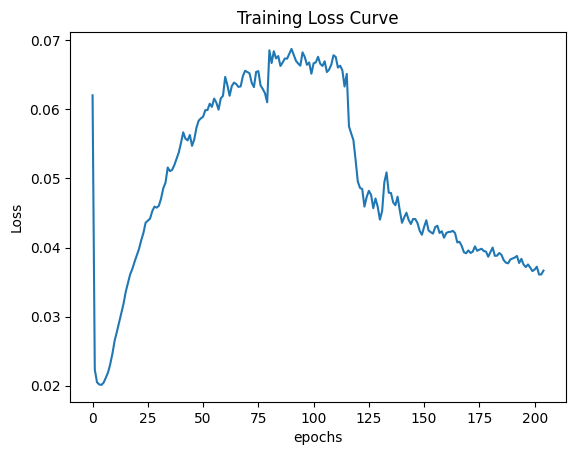

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [16]:
# %load_ext tensorboard

# %tensorboard --logdir=logs//SplitFSSL_BYOL32_DifAvgtimes --bind_all --port=7057